# Import

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import warnings
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
import optuna
import pickle
from sklearn.preprocessing import LabelEncoder, StandardScaler


plt.rcParams['figure.figsize'] = [21, 9]
plt.rcParams['figure.dpi'] = 300

# 다크모드에 맞는 스타일 설정
plt.style.use('dark_background')

# 추가적인 커스터마이징 (옵션)
plt.rcParams.update({
    'axes.edgecolor': 'white',         # 축의 테두리 색상
    'axes.labelcolor': 'white',       # 축 라벨 색상
    'xtick.color': 'white',           # x축 눈금 색상
    'ytick.color': 'white',           # y축 눈금 색상
    'grid.color': 'gray',             # 그리드 라인 색상
    'grid.alpha': 0.3,                # 그리드 투명도
    'text.color': 'white',            # 텍스트 색상
    'figure.facecolor': '#121212',    # 전체 그림 배경색
    'axes.facecolor': '#121212',      # 축 배경색
    'legend.facecolor': '#1e1e1e',    # 범례 배경색
    'legend.edgecolor': 'white',      # 범례 테두리 색상
})
plt.rcParams['agg.path.chunksize'] = 10000
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
REDRAW = False

Original dataset: https://www.kaggle.com/datasets/schran/insurance-premium-prediction/data

# Load Data

In [56]:
# 캐글 노트북이면 True, 아니면 False
if 'KAGGLE_URL_BASE' in os.environ:
    train_data = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv', index_col=0)
    test_data = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv', index_col=0)
else:
    train_data = pd.read_csv('./kaggle/input/playground-series-s4e12/train.csv', index_col=0)
    test_data = pd.read_csv('./kaggle/input/playground-series-s4e12/test.csv', index_col=0)

In [57]:
train_data.columns = train_data.columns.str.lower().str.replace(' ', '_')
test_data.columns = test_data.columns.str.lower().str.replace(' ', '_')

# 타겟 변수 및 피처 분리
target_column = 'premium_amount'
data = pd.concat([train_data, test_data]).drop(columns=target_column)
y = train_data[target_column]
del train_data, test_data

In [58]:
# policy_start_date 피처 전처리
data['policy_start_date'] = pd.to_datetime(data['policy_start_date'])
data['policy_start_date'] = (data['policy_start_date'] - pd.to_datetime('1970-01-01')).dt.days

In [60]:
int_columns = data.select_dtypes(include=['int64']).columns
float_columns = data.select_dtypes(include=['float64']).columns
categorical_columns = data.select_dtypes(include='object').columns
numerical_columns = int_columns.tolist() + float_columns.tolist()

In [61]:
data[int_columns]

,policy_start_date
id,
0,19714
1,19520
2,19630
3,19886
4,18962
...,...
1999995,18817
1999996,19444
1999997,18169


In [35]:
# --- 2. 결측치 처리 ---
# 범주형 변수의 결측치를 'unknown'으로 대체
categorical_columns = data.select_dtypes(include='object').columns
for col in categorical_columns:
    data[col].fillna('unknown', inplace=True)

# 수치형 변수의 결측치를 최대값 + 10%로 대체
float_columns = data.select_dtypes(include=['float64']).columns
for col in float_columns:
    data[col].fillna(data[col].max() * 1.1, inplace=True)
    
int_columns = data.select_dtypes(include=['int64']).columns
for col in int_columns:
    data[col].fillna(data[col].max()+int(data[col].std()), inplace=True)
numerical_columns = float_columns.append(int_columns)

# --- 3. 범주형 변수 인코딩 및 수치형 스케일링 ---
# 범주형 변수 인코딩
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# 수치형 변수 스케일링
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])
data[target_column] = y

# Devide Dataset

In [37]:
y = data.premium_amount.dropna().values

y_scaler = StandardScaler().fit(np.log1p(y).reshape(-1,1))
y = y_scaler.transform(np.log1p(y).reshape(-1,1)).reshape(-1)

In [39]:
X = data[data[target_column].notnull()].drop(columns=[target_column])

In [40]:
def inverse_y(y):
    return np.expm1(y_scaler.inverse_transform(y.reshape(-1,1)).reshape(-1))

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X.values, y, test_size=0.2, random_state=42)

# Modeling

In [21]:
from sklearn.metrics import mean_squared_log_error, r2_score, mean_squared_error

def evaluate_model(model, X_val, y_val):
    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    
    
    y_pred = inverse_y(y_pred)
    y_val = inverse_y(y_val)
    
    rmsle = mean_squared_log_error(y_val, y_pred) ** (1/2)
    return r2, mse, rmsle

def rmsle(y_true, y_pred):
    y_true = inverse_y(y_true)
    y_pred = inverse_y(y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [92]:
# TODO: Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1, max_depth=20, verbose=1)
rf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished


RandomForestRegressor(max_depth=15, n_estimators=500, n_jobs=-1,
                      random_state=42, verbose=1)

In [93]:
rf.score(X_val, y_val)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.9s finished


-0.0014465343707852352

In [196]:
from xgboost import XGBRFRegressor
xgbrf = XGBRFRegressor(n_estimators=500, random_state=42, n_jobs=-1, max_depth=20, verbose=1, gpu_id=0)
xgbrf.fit(X_train, y_train)

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None, gpu_id=0,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=20, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=500, n_jobs=-1,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=42, ...)

In [197]:
evaluate_model(xgbrf, X_val, y_val)

(0.06902026686920126, 0.9319795406727515, 1.0578987187101034)

In [195]:
# TODO: XGBoost Regressor
from xgboost import XGBRegressor
import xgboost as xgb
# early_stopping_rounds
early_stop = xgb.callback.EarlyStopping(
    rounds=10, metric_name='rmse', data_name='validation_0', save_best=True
)
xgbr = XGBRegressor(
    n_estimators=500,
    max_depth=15,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    objective='reg:squarederror',
    # eval_metric='r2',
    gpu_id=0,
    # num_parallel_tree=1,
    callbacks=[early_stop]
)
xgbr.fit(X_train, y_train, eval_set=[(X_val, y_val)])
evaluate_model(xgbr, X_val, y_val)

[0]	validation_0-rmse:0.99343
[1]	validation_0-rmse:0.98772
[2]	validation_0-rmse:0.98327
[3]	validation_0-rmse:0.97971
[4]	validation_0-rmse:0.97686
[5]	validation_0-rmse:0.97472
[6]	validation_0-rmse:0.97294
[7]	validation_0-rmse:0.97150
[8]	validation_0-rmse:0.97048
[9]	validation_0-rmse:0.96965
[10]	validation_0-rmse:0.96902
[11]	validation_0-rmse:0.96856
[12]	validation_0-rmse:0.96823
[13]	validation_0-rmse:0.96801
[14]	validation_0-rmse:0.96787
[15]	validation_0-rmse:0.96792
[16]	validation_0-rmse:0.96788
[17]	validation_0-rmse:0.96795
[18]	validation_0-rmse:0.96806
[19]	validation_0-rmse:0.96814
[20]	validation_0-rmse:0.96820
[21]	validation_0-rmse:0.96832
[22]	validation_0-rmse:0.96842
[23]	validation_0-rmse:0.96858
[24]	validation_0-rmse:0.96874


(0.06422812768443154, 0.936776826282012, 1.060617946522593)

In [68]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, 
           shuffle=False, 
        #    random_state=42
)
[(train_idx, val_idx) for train_idx, val_idx in kf.split(X)][3]


(array([      0,       1,       2, ..., 1199997, 1199998, 1199999]),
 array([720000, 720001, 720002, ..., 959997, 959998, 959999]))

In [42]:
# TODO: LightGBM Regressor
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(
    num_leaves=31,
    min_child_samples=7,
    min_child_weight=0.003,
    
    n_estimators=500,
    max_depth=30,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    verbosity=1,
)

lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1147
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 19
[LightGBM] [Info] Start training from score -0.000037


LGBMRegressor(max_depth=30, min_child_samples=7, min_child_weight=0.003,
              n_estimators=500, n_jobs=-1, random_state=42, verbosity=1)

In [43]:
evaluate_model(lgbm, X_val, y_val)

(0.08857439677075307, 0.9124044109944525, 1.0467298032672498)

In [199]:
import optuna, lightgbm as lgb
# Define Optuna optimization function
def objective(trial):
    # Define parameter search space
    param = {
        "objective": "regression",
        "metric": "rmlse",
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "num_leaves": trial.suggest_int("num_leaves", 15, 512),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        "n_estimators": 500,
        
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_depth": trial.suggest_int("max_depth", 5, 200),  # -1 means no limit
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-4, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-4, 10.0),
        # "device_type": "gpu",  # Enable GPU support
        "seed" : 42

    }

    # Create a LightGBM dataset
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    # Train LightGBM model
    model = lgb.train(
        param,
        dtrain,
        valid_sets=[dval],
    )

    # Predict on validation set
    y_val_pred = model.predict(X_val)
    
    # Compute RMSLE using sklearn's root_mean_squared_log_error
    _rmsle = rmsle(y_val, y_val_pred)
    return _rmsle

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=5)

[I 2024-12-24 18:44:03,647] A new study created in memory with name: no-name-029ee1a6-d707-477d-b9a9-85511ade99df


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009703 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 22
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=16 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Info] Start training from score -0.000037


[I 2024-12-24 18:49:07,478] Trial 0 finished with value: 1.0930456087500724 and parameters: {'boosting_type': 'dart', 'num_leaves': 185, 'min_child_samples': 16, 'learning_rate': 0.0006703932884466171, 'feature_fraction': 0.6838248922759205, 'bagging_fraction': 0.9160087919922216, 'bagging_freq': 12, 'min_data_in_leaf': 100, 'max_depth': 173, 'lambda_l1': 0.004075251489015327, 'lambda_l2': 0.0006262886655034381}. Best is trial 0 with value: 1.0930456087500724.


[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 22
[LightGBM] [Warning] min_data_in_leaf is set=45, min_child_samples=43 will be ignored. Current value: min_data_in_leaf=45
[LightGBM] [Info] Start training from score -0.000037


[I 2024-12-24 18:49:28,540] Trial 1 finished with value: 1.0519475307974724 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'min_child_samples': 43, 'learning_rate': 0.010838852422368019, 'feature_fraction': 0.8827215219292237, 'bagging_fraction': 0.7279662830094517, 'bagging_freq': 6, 'min_data_in_leaf': 45, 'max_depth': 16, 'lambda_l1': 0.006108375322971892, 'lambda_l2': 3.0653687198877426}. Best is trial 1 with value: 1.0519475307974724.


[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 22
[LightGBM] [Warning] min_data_in_leaf is set=38, min_child_samples=54 will be ignored. Current value: min_data_in_leaf=38
[LightGBM] [Info] Start training from score -0.000037


[I 2024-12-24 18:50:09,688] Trial 2 finished with value: 1.0520045443049426 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 311, 'min_child_samples': 54, 'learning_rate': 0.013509698015278303, 'feature_fraction': 0.6837075372637945, 'bagging_fraction': 0.8838677988728989, 'bagging_freq': 5, 'min_data_in_leaf': 38, 'max_depth': 152, 'lambda_l1': 0.000670379045715733, 'lambda_l2': 0.0007037549896657516}. Best is trial 1 with value: 1.0519475307974724.


[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 22
[LightGBM] [Warning] min_data_in_leaf is set=69, min_child_samples=23 will be ignored. Current value: min_data_in_leaf=69
[LightGBM] [Info] Start training from score -0.000037


[I 2024-12-24 18:52:52,853] Trial 3 finished with value: 1.0937843257647026 and parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'min_child_samples': 23, 'learning_rate': 0.00039315964928076324, 'feature_fraction': 0.8296992037157771, 'bagging_fraction': 0.7819775428519388, 'bagging_freq': 8, 'min_data_in_leaf': 69, 'max_depth': 163, 'lambda_l1': 0.006610516904176602, 'lambda_l2': 0.0067410864084444504}. Best is trial 1 with value: 1.0519475307974724.


[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1155
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 22
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Info] Start training from score -0.000037


[I 2024-12-24 18:53:24,136] Trial 4 finished with value: 1.0518501665687392 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 243, 'min_child_samples': 28, 'learning_rate': 0.03172662936937163, 'feature_fraction': 0.8002588375416329, 'bagging_fraction': 0.8975756113599461, 'bagging_freq': 12, 'min_data_in_leaf': 58, 'max_depth': 67, 'lambda_l1': 0.00018080500225635786, 'lambda_l2': 0.0009810884718940685}. Best is trial 4 with value: 1.0518501665687392.


In [200]:
study.best_params, study.best_value

({'boosting_type': 'gbdt',
  'num_leaves': 243,
  'min_child_samples': 28,
  'learning_rate': 0.03172662936937163,
  'feature_fraction': 0.8002588375416329,
  'bagging_fraction': 0.8975756113599461,
  'bagging_freq': 12,
  'min_data_in_leaf': 58,
  'max_depth': 67,
  'lambda_l1': 0.00018080500225635786,
  'lambda_l2': 0.0009810884718940685},
 1.0518501665687392)

In [201]:
best_lgbm = LGBMRegressor(**study.best_params)
best_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)])

[LightGBM] [Warning] lambda_l1 is set=0.00018080500225635786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018080500225635786
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.8002588375416329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8002588375416329
[LightGBM] [Warning] bagging_fraction is set=0.8975756113599461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8975756113599461
[LightGBM] [Warning] lambda_l2 is set=0.0009810884718940685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009810884718940685
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] lambda_l1 is set=0.00018080500225635786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018080500225635786
[LightGBM] [Warning] bagging_freq is set=12, 

LGBMRegressor(bagging_fraction=0.8975756113599461, bagging_freq=12,
              feature_fraction=0.8002588375416329,
              lambda_l1=0.00018080500225635786, lambda_l2=0.0009810884718940685,
              learning_rate=0.03172662936937163, max_depth=67,
              min_child_samples=28, min_data_in_leaf=58, num_leaves=243)

In [202]:
evaluate_model(best_lgbm, X_val, y_val)

[LightGBM] [Warning] lambda_l1 is set=0.00018080500225635786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018080500225635786
[LightGBM] [Warning] bagging_freq is set=12, subsample_freq=0 will be ignored. Current value: bagging_freq=12
[LightGBM] [Warning] feature_fraction is set=0.8002588375416329, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8002588375416329
[LightGBM] [Warning] bagging_fraction is set=0.8975756113599461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8975756113599461
[LightGBM] [Warning] lambda_l2 is set=0.0009810884718940685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009810884718940685
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=28 will be ignored. Current value: min_data_in_leaf=58


(0.07852547972348811, 0.9224641198803523, 1.0524843414042437)

In [203]:
evaluate_model(lgbm, X_val, y_val)

(0.07981171525655373, 0.9211765030197014, 1.0517495324313206)

In [138]:
lgbm.score(X_val, y_val)

0.07646312027622981

In [215]:
ans=inverse_y(lgbm.predict(scaled_test))

In [216]:
pd.Series(ans, index = test_data.index).rename('Premium Amount').to_csv('submission.csv', header=True)

,feature,importance
1,log_annual_income,2474
5,health_score_filled,2133
10,credit_score_filled_with_mean,2111
12,policy_start_date_days,1790
0,age_filled,1163
9,vehicle_age_categorical,854
11,insurance_duration_filled,602
8,previous_claims_categorical,599
13,customer_feedback_categorical,387
2,number_of_dependents_filled,371


<Axes: xlabel='feature'>

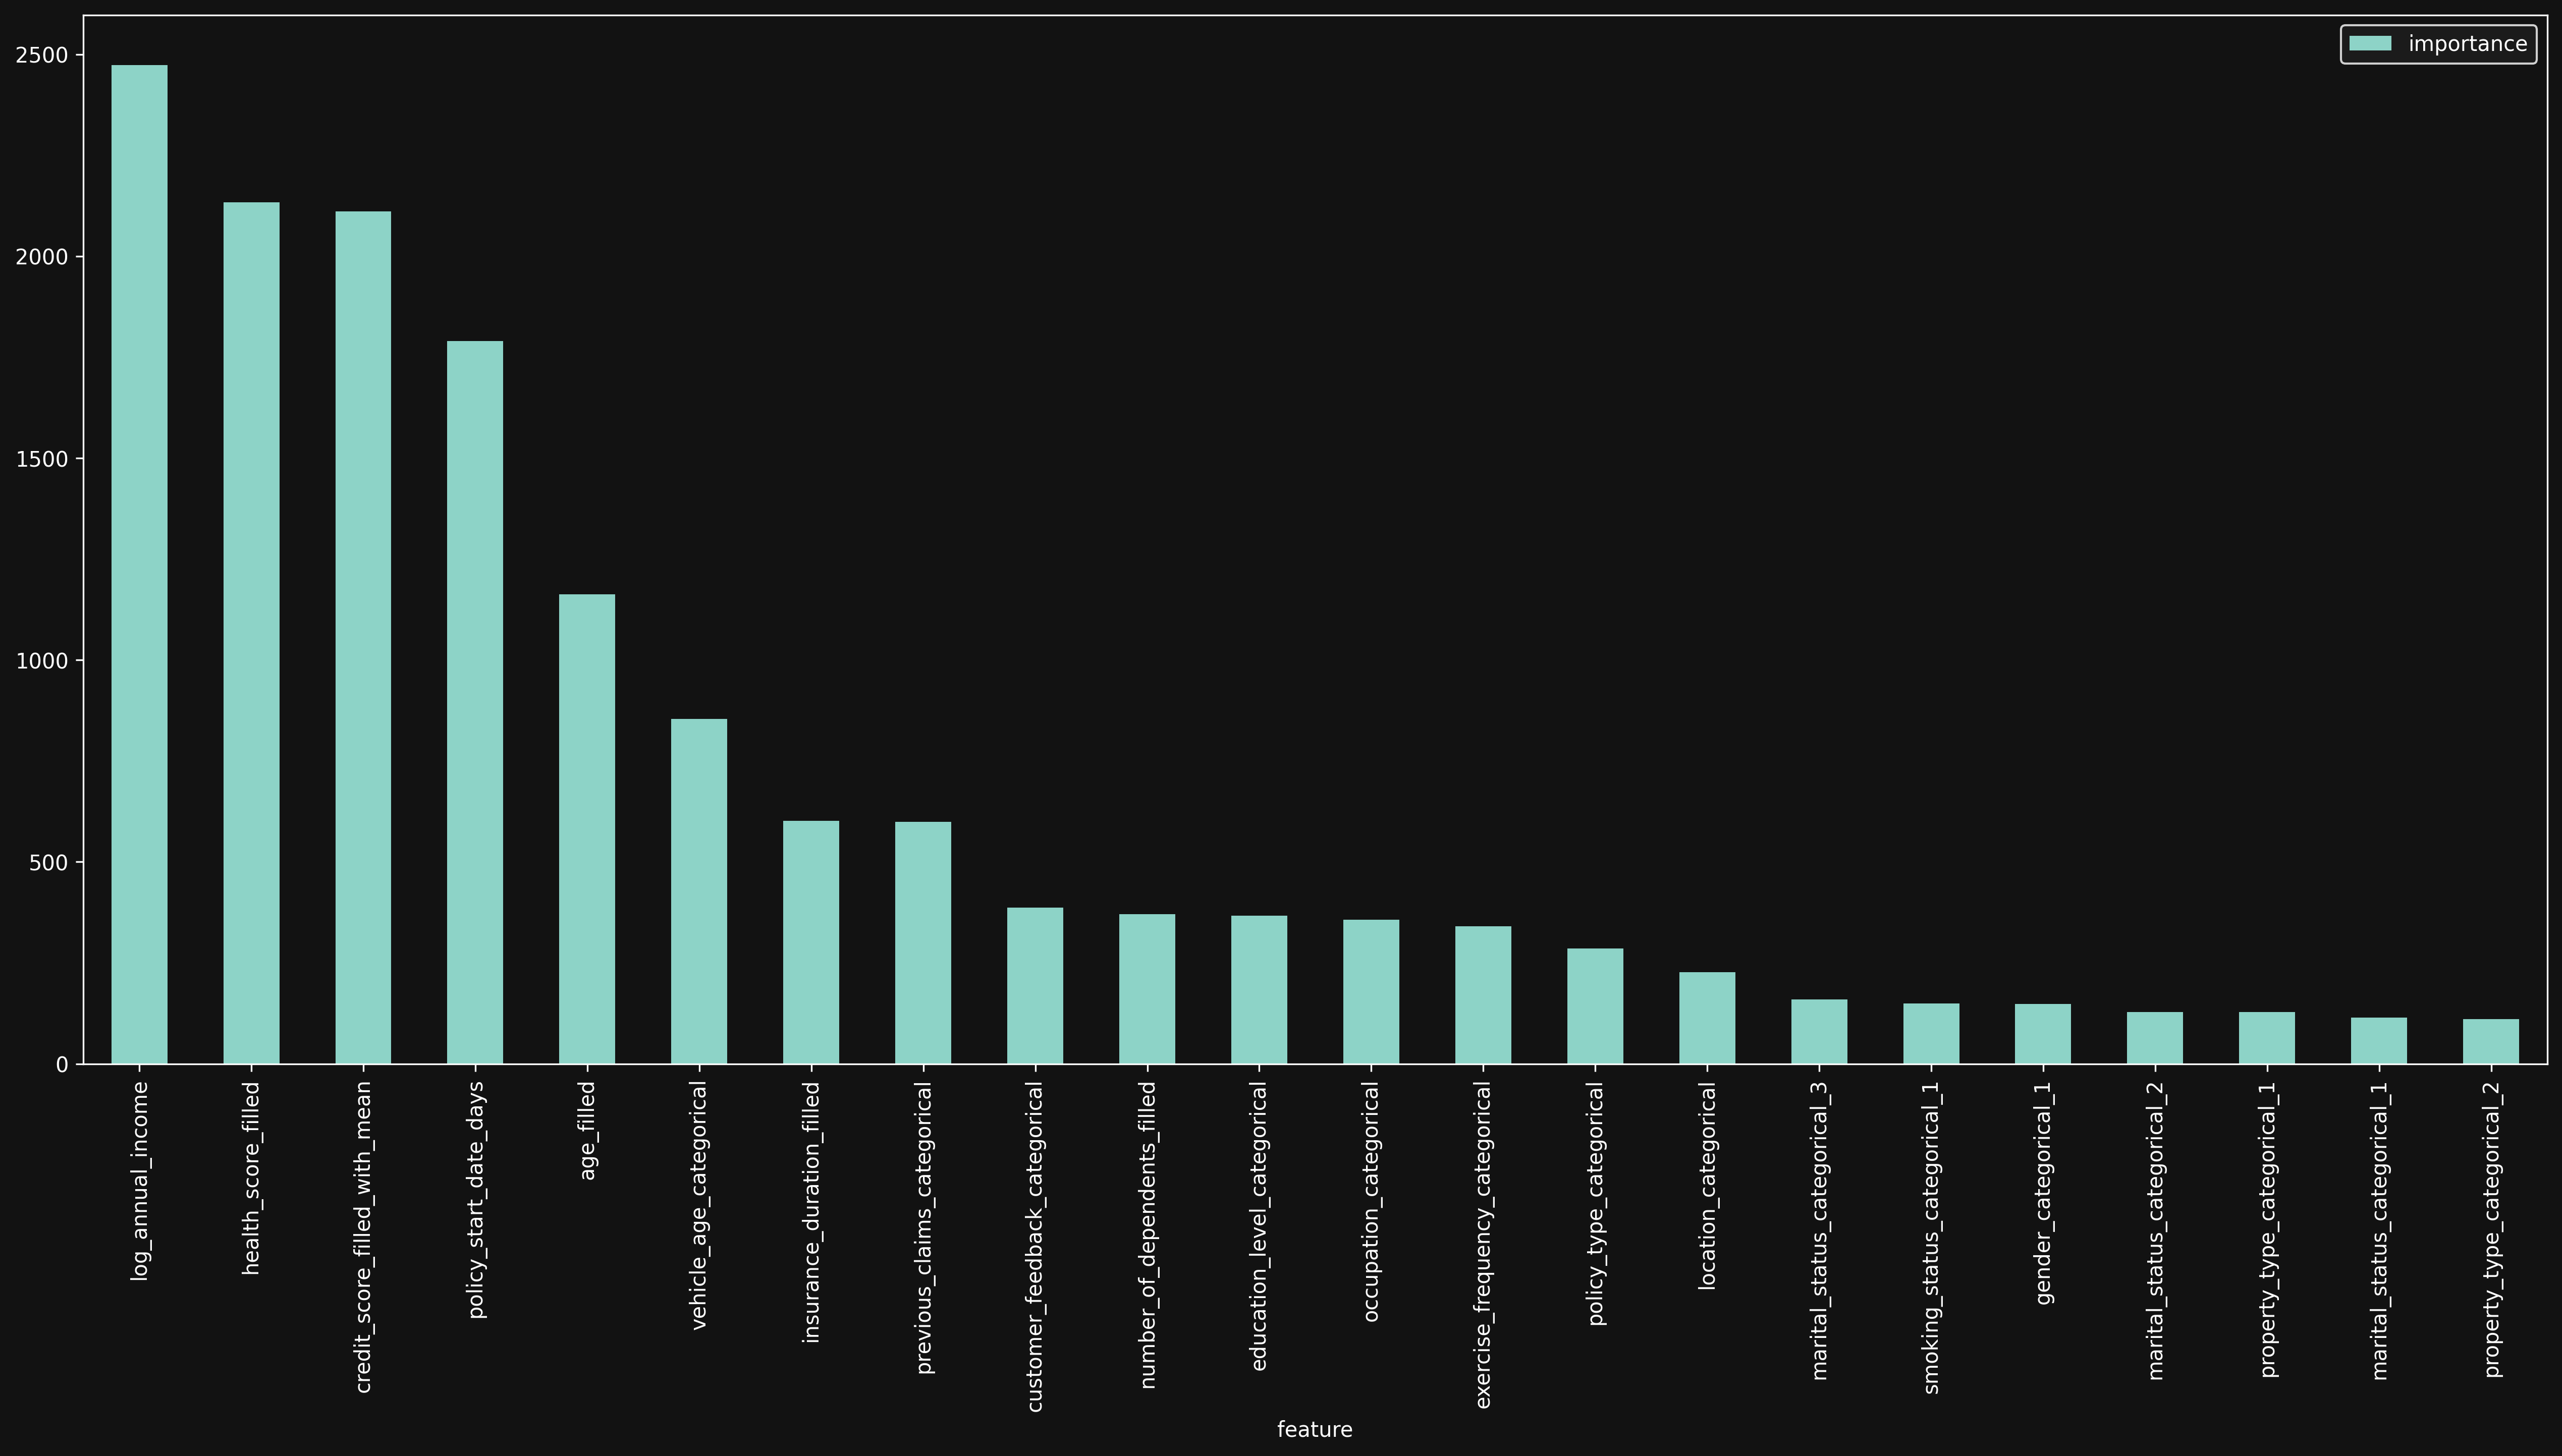

In [123]:
# visualize lgbm feature importance

lgbm.feature_importances_

feature_importance = pd.DataFrame({
    'feature': train_columns,
    'importance': lgbm.feature_importances_
}).sort_values('importance', ascending=False)
display(feature_importance)
feature_importance.plot.bar('feature', 'importance')


,feature,importance
1,log_annual_income,2405
10,credit_score_filled_with_mean,2135
5,health_score_filled,2091
12,policy_start_date_days,1793
0,age_filled,1140
9,vehicle_age_categorical,908
8,previous_claims_categorical,638
11,insurance_duration_filled,621
2,number_of_dependents_filled,414
13,customer_feedback_categorical,365


<Axes: xlabel='feature'>

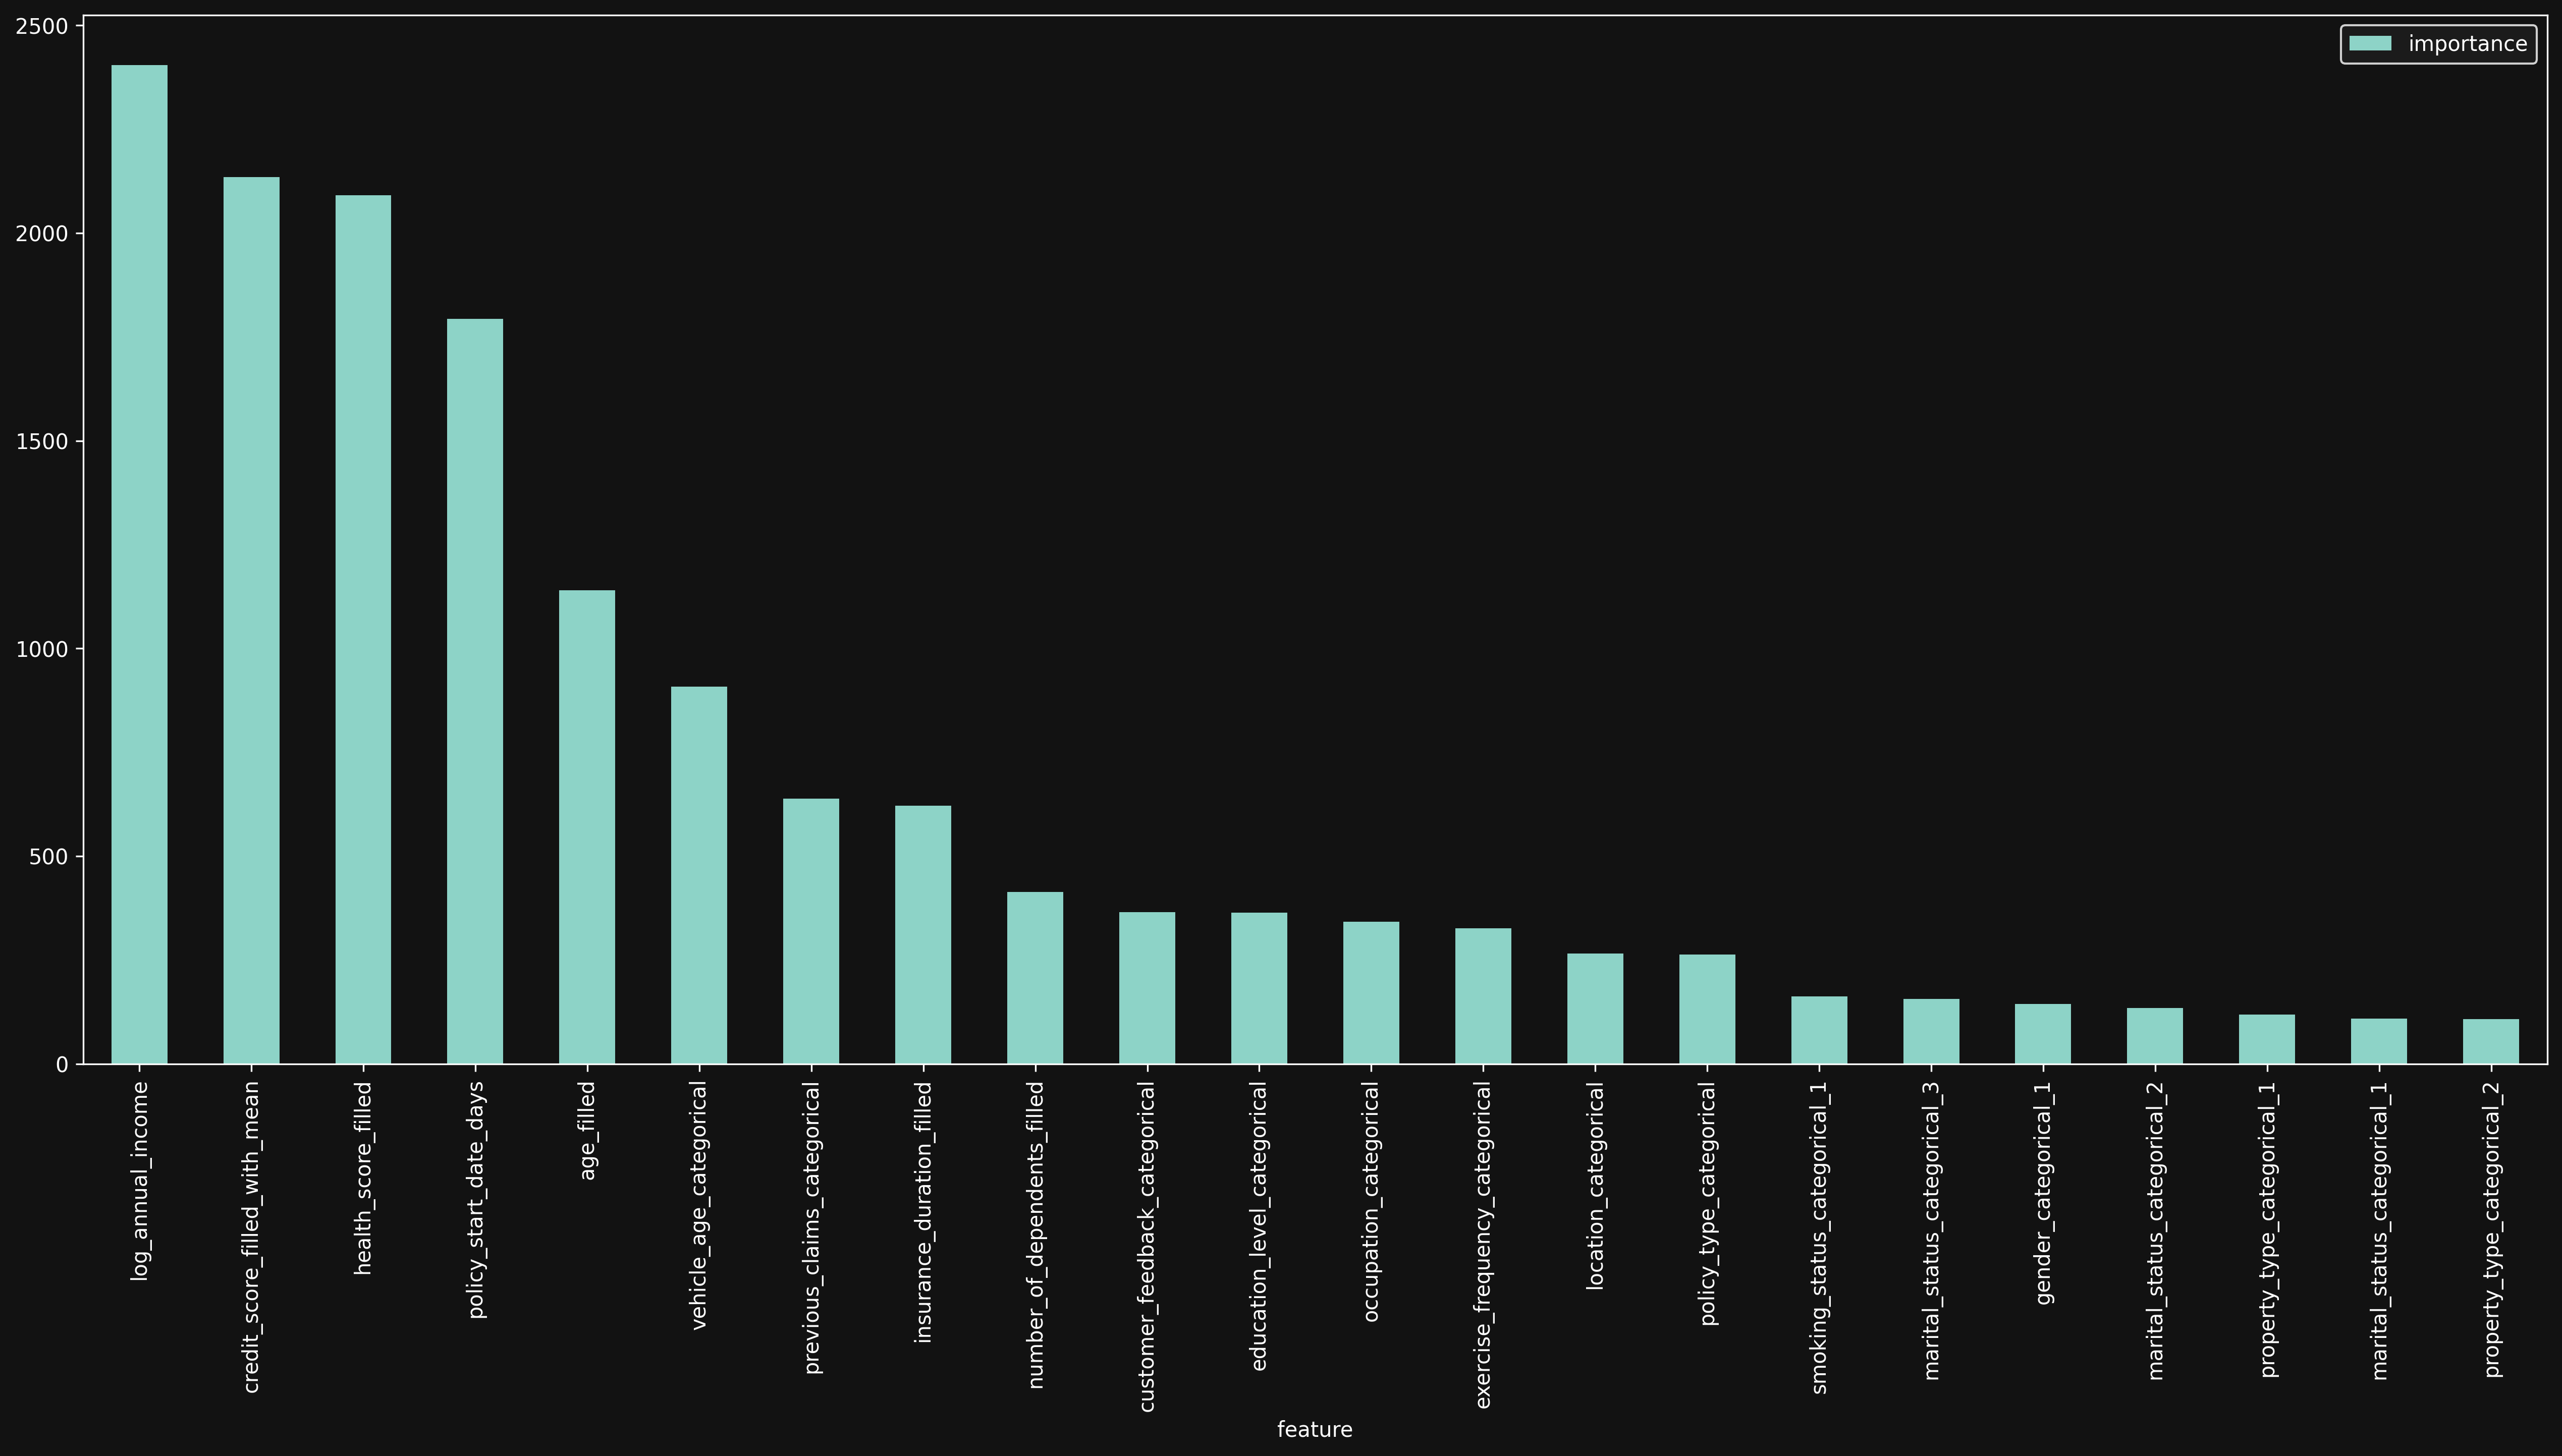

In [116]:
# visualize lgbm feature importance

lgbm.feature_importances_

feature_importance = pd.DataFrame({
    'feature': train_columns,
    'importance': lgbm.feature_importances_
}).sort_values('importance', ascending=False)
display(feature_importance)
feature_importance.plot.bar('feature', 'importance')


In [209]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(
    num_leaves=31,
    min_child_samples=20,
    min_child_weight=0.001,
    
    n_estimators=500,
    max_depth=20,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    # verbosity=1,
)

lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1146
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 22
[LightGBM] [Info] Start training from score -0.000037


LGBMRegressor(max_depth=20, n_estimators=500, n_jobs=-1, random_state=42,
              verbosity=1)

In [210]:
evaluate_model(lgbm, X_val, y_val)

(0.07987072638697967, 0.921117428515422, 1.0517158078529159)

In [ ]:
# SVM
from sklearn.svm import SVR
svr = SVR(
    C=1,
    epsilon=2.25,
)
svr.fit(X_train, y_train)

In [218]:
import pickle
svr = pd.read_pickle('svr.pkl')

In [75]:
# save svr model because it takes too long to train
import pickle
with open('svr.pkl', 'wb') as f:
    pickle.dump(svr, f)

In [220]:
evaluate_model(svr, X_val[:, 1:], y_val)

(-0.41186115869286777, 1.4133773994706387, 1.3027766711381177)

# Submission

In [50]:
test = data[data[target_column].isna()].drop(columns=[target_column])

In [52]:
def make_ans(model):
    ans=inverse_y(model.predict(test.values))
    return pd.Series(ans, index = test.index).rename('Premium Amount')

In [54]:
ans = make_ans(lgbm)
ans.to_csv('submission.csv', header=True)